In [1]:
import pyximport
pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy
from gammapy.maps import Map
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    GaussianSpatialModel,
    Models,
    FoVBackgroundModel,
)
import sys
sys.path.append('/home/katrin/Documents/nuisance_summary/')
from Dataset_Creation import sys_dataset
import Dataset_load 

In [2]:
figformat = 'png'

In [3]:
dataset_asimov = Dataset_load.create_asimov()

needs update?
update
_compute_flux_spatial
_compute_flux_spatial_geom
apply_psf


<AxesSubplot: xlabel='True Energy [TeV]', ylabel='Containment radius (deg)'>

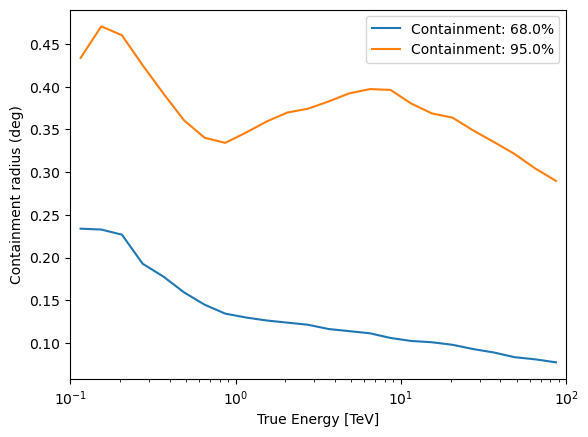

In [4]:
dataset_asimov.psf.plot_containment_radius_vs_energy()

<AxesSubplot: xlabel='Rad (deg)', ylabel='PSF (None)'>

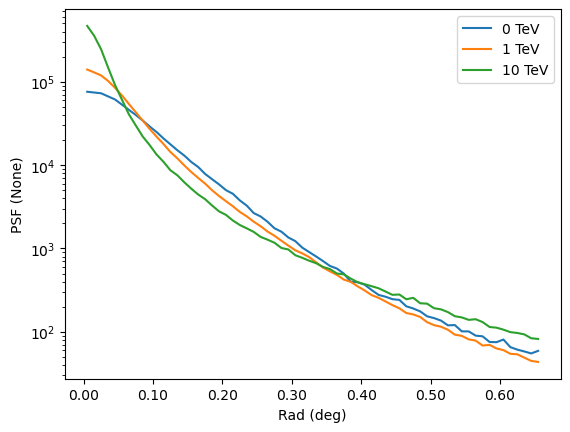

In [5]:
dataset_asimov.psf.plot_psf_vs_rad(energy_true = [0.5, 1, 10] *u.TeV)

<WCSAxesSubplot: >

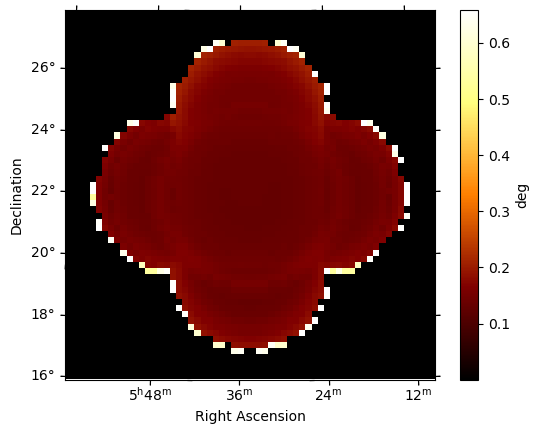

In [6]:
dataset_asimov.psf.containment_radius_map(1*u.TeV).plot(add_cbar = 1)

### How does it get evaluated?

<WCSAxesSubplot: >

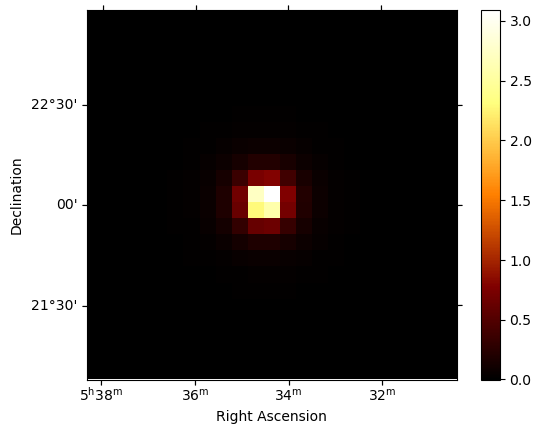

In [7]:
dataset_asimov.evaluators['Source'].compute_flux_spatial().sum_over_axes().plot(add_cbar=1)

In [8]:
from gammapy.irf import PSFMap, PSFKernel

def create_gaussian(psf, sigma):

    psf_g = PSFMap.from_gauss(energy_axis_true = psf.psf_map.geom.axes['energy_true'],
                        sigma = sigma*u.deg,
                          geom = psf.psf_map.geom.to_image(),
                          rad_axis = psf.psf_map.geom.axes['rad'],
                         )
    return psf_g


In [9]:
type(dataset_asimov.psf)

gammapy.irf.psf.map.PSFMap

In [10]:
psf_g = create_gaussian(dataset_asimov.psf, 0.1)

In [11]:
from astropy.visualization import quantity_support
from matplotlib.ticker import FormatStrFormatter
def plot_psf_vs_rad(psf, ax=None, energy_true=[0.1, 1, 10] * u.TeV,energy_name='energy', label = None,**kwargs):
    """Plot PSF vs radius.

    The method plots the profile at the center of the map.

    Parameters
    ----------
    ax : `~matplotlib.pyplot.Axes`
        Axes to plot on.
    energy : `~astropy.units.Quantity`
        Energies where to plot the PSF.
    **kwargs : dict
        Keyword arguments pass to `~matplotlib.pyplot.plot`.

    Returns
    -------
    ax : `~matplotlib.pyplot.Axes`
         Axes to plot on.

    """
    ax = plt.gca() if ax is None else ax

    rad = psf.psf_map.geom.axes["rad"].center

    for value in energy_true:
        psf_value = psf.psf_map.interp_by_coord(
            {
                "skycoord": psf.psf_map.geom.center_skydir,
                energy_name: value,
                "rad": rad,
            }
        )
        if label is None:
            label = f"{value:.0f}"
        with quantity_support():
            ax.plot(rad**2, psf_value, label=label, **kwargs)

    ax.set_yscale("log")
    ax.set_xlabel(f"Rad **2  ({ax.xaxis.units})")
    ax.set_ylabel(f"PSF ({ax.yaxis.units})")
    ax.xaxis.set_major_formatter(FormatStrFormatter("%.2f"))
    plt.legend()
    return ax

<AxesSubplot: xlabel='Rad **2  (deg2)', ylabel='PSF (None)'>

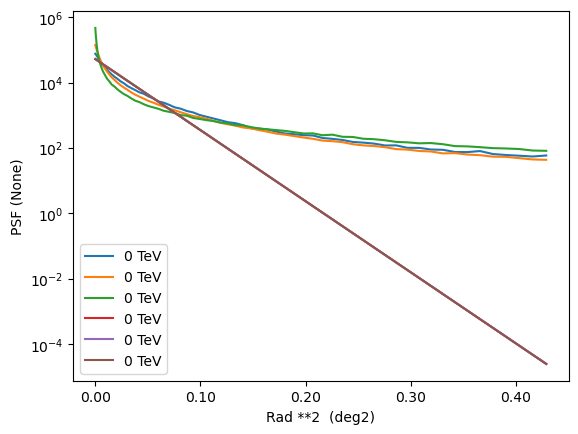

In [12]:
plot_psf_vs_rad(dataset_asimov.psf, ax=None, energy_true=[0.5, 1, 10] * u.TeV,energy_name='energy_true')
plot_psf_vs_rad(psf_g, ax=None, energy_true=[0.5, 1, 10] * u.TeV,energy_name='energy_true')


In [13]:
sr = psf_g.get_psf_kernel(dataset_asimov.exposure.geom).to_image().psf_kernel_map.geom.solid_angle().flatten()

In [14]:
pp = psf_g.get_psf_kernel(dataset_asimov.exposure.geom).data[10].flatten()

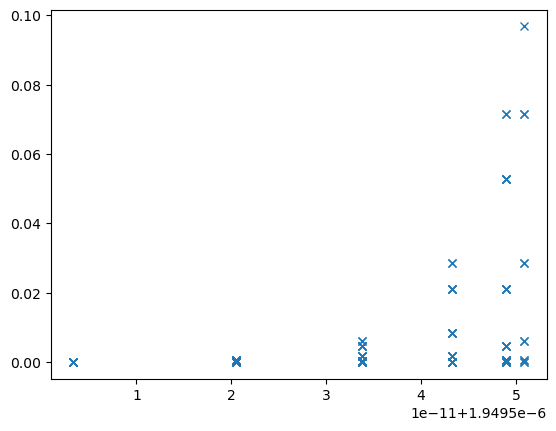

In [15]:
plt.plot(sr, pp, 'x')

<WCSAxesSubplot: >

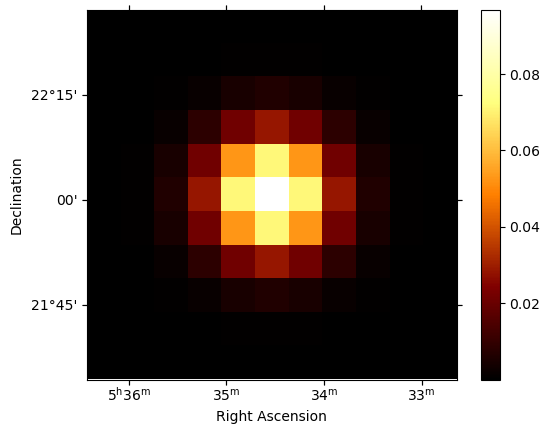

In [16]:
psf_g.get_psf_kernel(dataset_asimov.exposure.geom).to_image().psf_kernel_map.plot(ax=None, add_cbar=1)

<AxesSubplot: xlabel='Rad (deg)', ylabel='PSF (None)'>

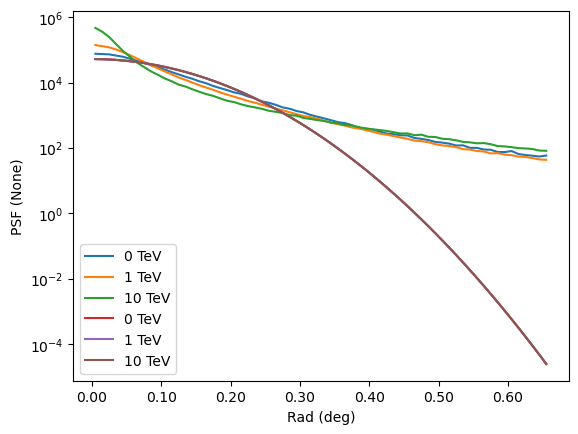

In [17]:
ax = dataset_asimov.psf.plot_psf_vs_rad(energy_true = [0.5, 1, 10] *u.TeV)
psf_g = create_gaussian(dataset_asimov.psf, 0.1)
psf_g.plot_psf_vs_rad(energy_true = [0.5, 1, 10] *u.TeV, ax = ax)

In [18]:
def normalize(t, base):
    """Force normalisation of the kernel"""
    data = t.data
    if t.geom.is_image:
        axis = (0, 1)
    else:
        axis = (1, 2)

    data = np.nan_to_num(data / base.data.sum(axis=axis, keepdims=True))
    t.data = data

In [19]:
dataset_bad = Dataset_load.create_asimov()
normalize(psf_g.psf_map, dataset_asimov.psf.psf_map)
dataset_bad.psf = psf_g


needs update?
update
_compute_flux_spatial
_compute_flux_spatial_geom
apply_psf


/tmp/ipykernel_8311/664362423.py:9: RuntimeWarning: divide by zero encountered in true_divide
  data = np.nan_to_num(data / base.data.sum(axis=axis, keepdims=True))


needs update?
update
_compute_flux_spatial
_compute_flux_spatial_geom
apply_psf


<WCSAxesSubplot: >

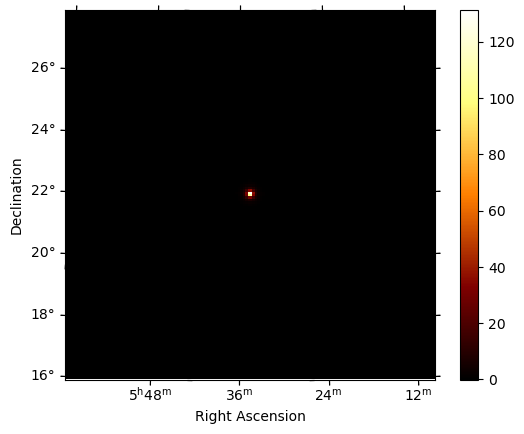

In [20]:
n=dataset_asimov.npred_signal().sum_over_axes()
n.plot(add_cbar=1)

needs update?
update
_compute_flux_spatial
_compute_flux_spatial_geom
apply_psf


/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in accumulate
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


<WCSAxesSubplot: >

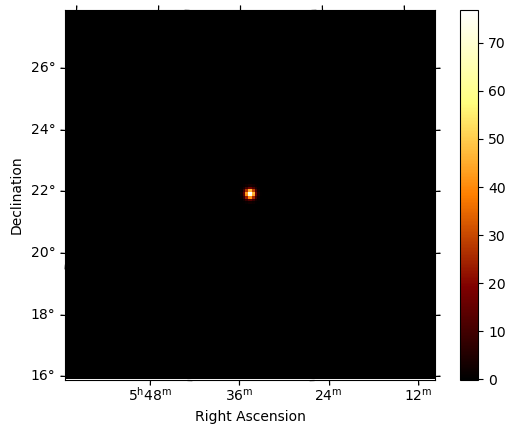

In [21]:
nb = dataset_bad.npred_signal().sum_over_axes()
nb.plot(add_cbar=1)

#### Shifting up

In [39]:
def create_uni(value,psf):
    psf_uni = psf.copy()
    psf_uni.psf_map.data = value
    return psf_uni

In [55]:
ee = np.linspace(0.9, 1.1, (psf_uni.psf_map.data.shape[1]))
len(ee)

66

In [59]:
psf_uni.psf_map.data[:,e,:,:]

array([[[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       ...,

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 

In [58]:
for e in range(len(ee)):
    psf_uni.psf_map.data[:,e,:,:] *= ee[e]

UFuncTypeError: Cannot cast ufunc 'multiply' output from dtype('float64') to dtype('int64') with casting rule 'same_kind'

In [ ]:
for e in range(len(ee)):
    plt.plot(psf_uni.psf_map.data[:,e,:,:] )

In [54]:
psf_uni.psf_map.data.shape

(24, 66, 60, 60)

In [57]:
psf_uni.psf_map.data[:,:,5,:]

array([[[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       ...,

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 

In [40]:
psf_uni = create_uni(1, psf_g)


<AxesSubplot: xlabel='Rad **2  (deg2)', ylabel='PSF (None)'>

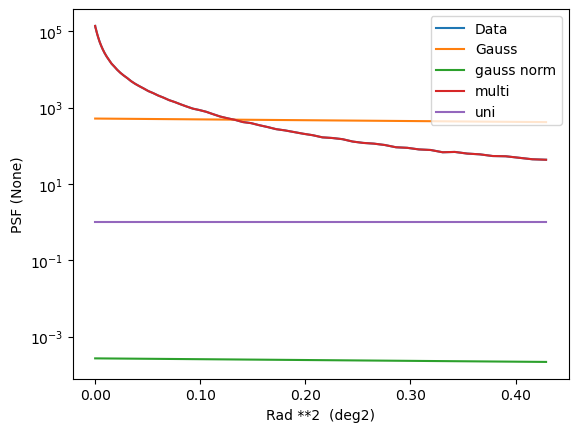

In [42]:
enes = [1] *u.TeV

psf_g = create_gaussian(dataset_asimov.psf, 1.)
t = dataset_asimov.psf.copy()
psf_g_norm = psf_g.copy()
psf_g_norm.psf_map.data /= psf_g.psf_map.data.sum(axis=(1,2), keepdims=True)
t.psf_map.data *= psf_uni.psf_map.data 
#t.psf_map.data *= dataset_asimov.psf.psf_map.data

plot_psf_vs_rad(dataset_asimov.psf, ax=None, energy_true=enes,energy_name='energy_true',
               label = "Data")
plot_psf_vs_rad(psf_g, ax=None, energy_true=enes,energy_name='energy_true',
               label = 'Gauss')
plot_psf_vs_rad(psf_g_norm, ax=None, energy_true=enes,energy_name='energy_true',
                label = "gauss norm")

plot_psf_vs_rad(t, ax=None, energy_true=enes,energy_name='energy_true',
               label = 'multi')
plot_psf_vs_rad(psf_uni, ax=None, energy_true=enes,energy_name='energy_true',
               label = 'uni')


In [43]:
dataset_shift = Dataset_load.create_asimov()
dataset_shift.psf = t

needs update?
update
_compute_flux_spatial
_compute_flux_spatial_geom
apply_psf


needs update?
update
_compute_flux_spatial
_compute_flux_spatial_geom
apply_psf


<WCSAxesSubplot: >

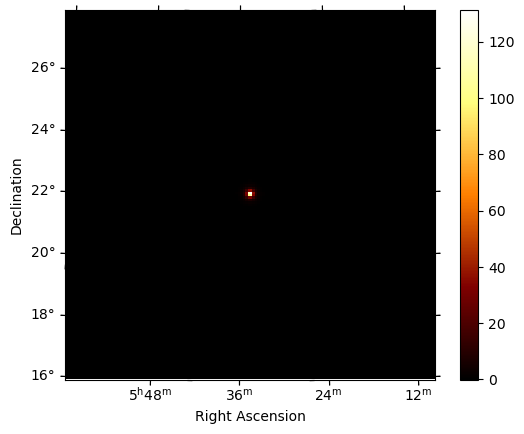

In [44]:
nt=dataset_shift.npred_signal().sum_over_axes()
nt.plot(add_cbar=1)

(60.0, 90.0)

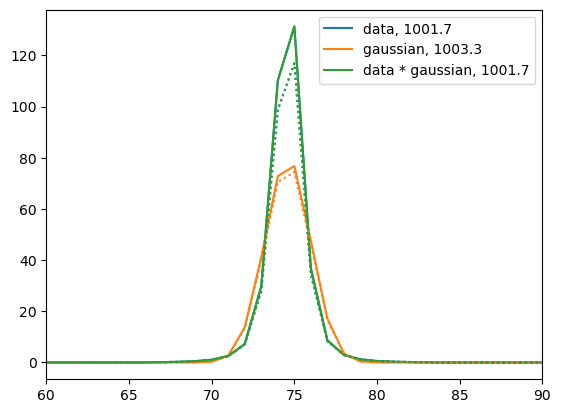

In [45]:
plt.plot(n.data[:,:,75][0], label=f'data, {n.data.sum():.5}')
plt.plot(nb.data[:,:,75][0], label =f'gaussian, {nb.data.sum():.5}')
plt.plot(nt.data[:,:,75][0], label = f'data * gaussian, {nt.data.sum():.5}')

plt.plot(n.data[:,:,74][0], label=f'', linestyle= 'dotted',
        color = 'tab:blue')
plt.plot(nb.data[:,:,74][0], label =f'', linestyle= 'dotted',
        color = 'tab:orange')
plt.plot(nt.data[:,:,74][0], label = f'', linestyle= 'dotted',
        color = 'tab:green')
plt.legend()
plt.xlim(60, 90)

<WCSAxesSubplot: >

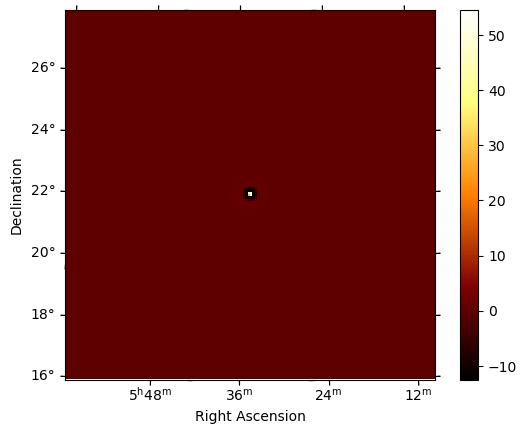

In [46]:
(n-nb).plot(add_cbar = 1)

<WCSAxesSubplot: >

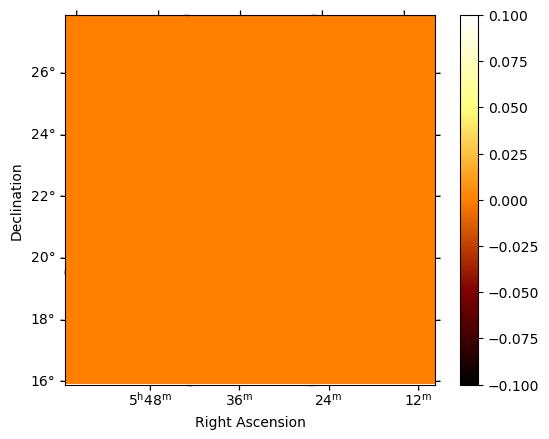

In [47]:
(n-nt).plot(add_cbar = 1)